MILP Model with constraints relating to:

1.) Battery Charging Efficiency

2.) Battery Discharging Efficiency

3.) Battery Capacity

4.) Battery Charge

5.) Minimum Battery Charge

6.) Charging Ramp Rate

7.) Discharging Ramp Rate

8.) Total Daily Volume

9.) Buy/Sell Activation

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus

# Load data
date_format = "%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat = pd.read_csv("/home/ciaran/QRA&Q-Ave(QR&CP)/DAM_QRA/QR/rf_Q_DAM_1-12.csv")
dat1 = pd.DataFrame(dat)

# Create quantile dataframes
quantiles = [10, 30, 50, 70, 90]
Q = {}
for q in quantiles:
    column_names = [f"EURPrices+{i}_Forecast_{q}" for i in range(24)]
    Q[q] = dat1[column_names].dropna().stack().reset_index()
    Q[q]["Price"] = Q[q].iloc[:, 2]

# Create a dataframe 'Y_r' with real price data
column_names = [f"EURPrices+{i}" for i in range(24)]
Y_r = dat1[column_names].dropna().stack().reset_index()
Y_r["Price"] = Y_r.iloc[:, 2]

# Set battery parameters
battery_efficiency_charge = 0.80
battery_efficiency_discharge = 0.98
Total_Daily_Volume = 2
max_battery_capacity = 1.0
min_battery_capacity = 0.0
ramp_rate_charge = 1
ramp_rate_discharge = 1

# Define time periods (24-hour windows)
time_periods = range(0, len(Y_r), 24)

# Define quantile pairs
quantile_pairs = [(0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]

# Initialize dictionaries to store total profits for each quantile pair
total_profits = {pair: 0 for pair in quantile_pairs}

# Initialize battery charge at the start of the first day
initial_charge = 0.0

# Loop through each quantile pair
for alpha, complement_alpha in quantile_pairs:
    results = []
    current_charge = initial_charge

    for start_idx in time_periods:
        end_idx = start_idx + 24

        if end_idx > len(Y_r):
            break

        # Find the appropriate quantiles
        alpha_key = int(alpha * 100)
        complement_alpha_key = int(complement_alpha * 100)

        if alpha_key not in Q or complement_alpha_key not in Q:
            continue

        p_max = Q[alpha_key]["Price"].iloc[start_idx:end_idx].values
        p_min = Q[complement_alpha_key]["Price"].iloc[start_idx:end_idx].values

        # Define MILP problem
        prob = LpProblem("Multiple_Trades_Quantile_Strategy", LpMaximize)

        # Define decision variables
        buy_action = LpVariable.dicts("Buy_Action", range(24), cat='Binary')
        sell_action = LpVariable.dicts("Sell_Action", range(24), cat='Binary')
        buy = LpVariable.dicts("Buy", range(24), lowBound=0, cat='Continuous')
        sell = LpVariable.dicts("Sell", range(24), lowBound=0, cat='Continuous')
        charge = LpVariable.dicts("Charge", range(25), lowBound=min_battery_capacity, upBound=max_battery_capacity, cat='Continuous')

        # Initial battery charge constraint
        prob += charge[0] == current_charge, "Initial_Charge"

        # Define the total daily volume constraint
        prob += lpSum([buy[t] for t in range(24)]) + lpSum([sell[t] for t in range(24)]) == Total_Daily_Volume, "Total_Daily_Volume"

        # Ensure that each hour has at most one buy or sell action
        for t in range(24):
            prob += buy_action[t] + sell_action[t] <= 1, f"One_Action_Per_Hour_{t}"

        # Link action variables to buy and sell variables
        for t in range(24):
            prob += buy[t] <= ramp_rate_charge * buy_action[t], f"Buy_Action_Link_{t}"
            prob += sell[t] <= ramp_rate_discharge * sell_action[t], f"Sell_Action_Link_{t}"

        # Battery charge constraints
        for t in range(24):
            prob += charge[t + 1] == charge[t] + buy[t] - sell[t], f"Charge_Update_{t}"
            prob += charge[t] <= max_battery_capacity, f"Max_Capacity_{t}"
            prob += charge[t] >= min_battery_capacity, f"Min_Capacity_{t}"

            # Charging constraints
            prob += buy[t] <= max_battery_capacity - charge[t], f"Charging_Constraint_{t}"
            prob += buy[t] <= ramp_rate_charge, f"Charging_Ramp_Rate_Constraint_{t}"

            # Discharging constraints
            prob += sell[t] <= charge[t] - min_battery_capacity, f"Discharging_Constraint_{t}"
            prob += sell[t] <= ramp_rate_discharge, f"Discharging_Ramp_Rate_Constraint_{t}"

        # Define the objective function (maximize profit)
            prob += lpSum([(battery_efficiency_discharge * p_max[t] * sell[t]) - ((p_min[t] / battery_efficiency_charge) * buy[t]) for t in range(24)])

        # Solve the problem
        prob.solve()

        # Check if the solution is optimal
        if LpStatus[prob.status] == 'Optimal':
            # Extract buy and sell times and amounts
            buy_times = [t for t in range(24) if buy[t].varValue > 0]
            sell_times = [t for t in range(24) if sell[t].varValue > 0]

            # Ensure unique buy-sell pairs
            used_hours = set()
            valid_trades = []
            for bt in buy_times:
                if bt in used_hours:
                    continue
                for st in sell_times:
                    if st in used_hours or bt >= st:
                        continue
                    valid_trades.append((bt, st))
                    used_hours.add(bt)
                    used_hours.add(st)
                    break  # Only one valid sell per buy to ensure no repeated actions

            for bt, st in valid_trades:
                # Calculate profit using real prices
                buy_price = Y_r.iloc[start_idx + bt]["Price"]
                sell_price = Y_r.iloc[start_idx + st]["Price"]
                buy_amount = buy[bt].varValue
                sell_amount = sell[st].varValue
                profit = (battery_efficiency_discharge * sell_price * sell_amount) - ((buy_price * buy_amount) / battery_efficiency_charge)
                results.append(profit)
                print(f"Day {start_idx // 24 + 1}, Alpha {alpha}-{complement_alpha}: Buy at {bt} ({buy_amount} MW), Sell at {st} ({sell_amount} MW), Profit: {profit}")


    # Calculate the sum of profits for the current quantile pair
    total_profit = sum(results)
    total_profits[(alpha, complement_alpha)] = total_profit
    print(f"Total Profit for Alpha {alpha}-{complement_alpha}: {total_profit}\n")

# Print the total profits for all quantile pairs
for pair, profit in total_profits.items():
    print(f"Total Profit for Alpha {pair[0]}-{pair[1]}: {profit}")


Total Profit for Alpha 0.5-0.5: 20678.09094999999

Total Profit for Alpha 0.3-0.7: 20819.97384999999

Total Profit for Alpha 0.1-0.9: 19693.199999999993

MILP with buy/sell activation based on real prices

In [ ]:
# Load data
date_format = "%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat = pd.read_csv("/home/ciaran/QRA&Q-Ave(QR&CP)/DAM_QRA/QR/rf_Q_DAM_1-12.csv")
dat1 = pd.DataFrame(dat)

# Create quantile dataframes
quantiles = [10, 30, 50, 70, 90]
Q = {}
for q in quantiles:
    column_names = [f"EURPrices+{i}_Forecast_{q}" for i in range(24)]
    Q[q] = dat1[column_names].dropna().stack().reset_index()
    Q[q]["Price"] = Q[q].iloc[:, 2]

# Create a dataframe 'Y_r' with real price data
column_names = [f"EURPrices+{i}" for i in range(24)]
Y_r = dat1[column_names].dropna().stack().reset_index()
Y_r["Price"] = Y_r.iloc[:, 2]

# Set battery parameters
battery_efficiency_charge = 0.80
battery_efficiency_discharge = 0.98
Total_Daily_Volume = 2
max_battery_capacity = 1.0
min_battery_capacity = 0.0
ramp_rate_charge = 1
ramp_rate_discharge = 1

# Define time periods (24-hour windows)
time_periods = range(0, len(Y_r), 24)

# Define quantile pairs
quantile_pairs = [(0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]

# Initialize dictionaries to store total profits for each quantile pair
total_profits = {pair: 0 for pair in quantile_pairs}

# Initialize battery charge at the start of the first day
initial_charge = 0.0

# Loop through each quantile pair
for alpha, complement_alpha in quantile_pairs:
    results = []
    current_charge = initial_charge

    for start_idx in time_periods:
        end_idx = start_idx + 24

        if end_idx > len(Y_r):
            break

        # Find the appropriate quantiles
        alpha_key = int(alpha * 100)
        complement_alpha_key = int(complement_alpha * 100)

        if alpha_key not in Q or complement_alpha_key not in Q:
            continue

        p_max = Q[alpha_key]["Price"].iloc[start_idx:end_idx].values
        p_min = Q[complement_alpha_key]["Price"].iloc[start_idx:end_idx].values

        # Define MILP problem
        prob = LpProblem("Multiple_Trades_Quantile_Strategy", LpMaximize)

        # Define decision variables
        buy_action = LpVariable.dicts("Buy_Action", range(24), cat='Binary')
        sell_action = LpVariable.dicts("Sell_Action", range(24), cat='Binary')
        buy = LpVariable.dicts("Buy", range(24), lowBound=0, cat='Continuous')
        sell = LpVariable.dicts("Sell", range(24), lowBound=0, cat='Continuous')
        charge = LpVariable.dicts("Charge", range(25), lowBound=min_battery_capacity, upBound=max_battery_capacity, cat='Continuous')

        # Initial battery charge constraint
        prob += charge[0] == current_charge, "Initial_Charge"

        # Define the total daily volume constraint
        prob += lpSum([buy[t] for t in range(24)]) + lpSum([sell[t] for t in range(24)]) == Total_Daily_Volume, "Total_Daily_Volume"

        # Ensure that each hour has at most one buy or sell action
        for t in range(24):
            prob += buy_action[t] + sell_action[t] <= 1, f"One_Action_Per_Hour_{t}"

        # Link action variables to buy and sell variables
        for t in range(24):
            prob += buy[t] <= ramp_rate_charge * buy_action[t], f"Buy_Action_Link_{t}"
            prob += sell[t] <= ramp_rate_discharge * sell_action[t], f"Sell_Action_Link_{t}"

        # Battery charge constraints
        for t in range(24):
            prob += charge[t + 1] == charge[t] + buy[t] - sell[t], f"Charge_Update_{t}"
            prob += charge[t] <= max_battery_capacity, f"Max_Capacity_{t}"
            prob += charge[t] >= min_battery_capacity, f"Min_Capacity_{t}"

            # Charging constraints
            prob += buy[t] <= max_battery_capacity - charge[t], f"Charging_Constraint_{t}"
            prob += buy[t] <= ramp_rate_charge, f"Charging_Ramp_Rate_Constraint_{t}"

            # Discharging constraints
            prob += sell[t] <= charge[t] - min_battery_capacity, f"Discharging_Constraint_{t}"
            prob += sell[t] <= ramp_rate_discharge, f"Discharging_Ramp_Rate_Constraint_{t}"

        # Define the objective function (maximize profit)
            prob += lpSum([(battery_efficiency_discharge * p_max[t] * sell[t]) - ((p_min[t] / battery_efficiency_charge) * buy[t]) for t in range(24)])

        # Solve the problem
        prob.solve()
        
        # Check if the solution is optimal
        if LpStatus[prob.status] == 'Optimal':
            # Extract buy and sell times and amounts
            buy_times = [t for t in range(24) if buy[t].varValue > 0]
            sell_times = [t for t in range(24) if sell[t].varValue > 0]

            # Ensure unique buy-sell pairs
            used_hours = set()
            valid_trades = []
            for bt in buy_times:
                if bt in used_hours:
                    continue
                for st in sell_times:
                    if st in used_hours or bt >= st:
                        continue
                    # Calculate expected profit using real prices
                    buy_price = Y_r.iloc[start_idx + bt]["Price"]
                    sell_price = Y_r.iloc[start_idx + st]["Price"]
                    expected_profit = (battery_efficiency_discharge * sell_price * sell[st].varValue) - ((buy_price * buy[bt].varValue) / battery_efficiency_charge)
                    # Only consider trades with positive expected profit
                    if expected_profit > 0:
                        valid_trades.append((bt, st))
                        used_hours.add(bt)
                        used_hours.add(st)
                        break  # Only one valid sell per buy to ensure no repeated actions

            for bt, st in valid_trades:
                # Calculate profit using real prices
                buy_price = Y_r.iloc[start_idx + bt]["Price"]
                sell_price = Y_r.iloc[start_idx + st]["Price"]
                buy_amount = buy[bt].varValue
                sell_amount = sell[st].varValue
                profit = (battery_efficiency_discharge * sell_price * sell_amount) - ((buy_price * buy_amount) / battery_efficiency_charge)
                results.append(profit)
                print(f"Day {start_idx // 24 + 1}, Alpha {alpha}-{complement_alpha}: Buy at {bt} ({buy_amount} MW), Sell at {st} ({sell_amount} MW), Profit: {profit}")

        # Calculate the sum of profits for the current quantile pair
        total_profit = sum(results)
        total_profits[(alpha, complement_alpha)] = total_profit
        print(f"Total Profit for Alpha {alpha}-{complement_alpha}: {total_profit}\n")


# Print the total profits for all quantile pairs
for pair, profit in total_profits.items():
    print(f"Total Profit for Alpha {pair[0]}-{pair[1]}: {profit}")


Total Profit for Alpha 0.5-0.5: 20718.530249999993

Total Profit for Alpha 0.3-0.7: 20863.75774999999

Total Profit for Alpha 0.1-0.9: 19760.580799999996

MILP with buy/sell activation based on predicted prices

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus

# Load data
date_format = "%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat = pd.read_csv("/home/ciaran/QRA&Q-Ave(QR&CP)/DAM_QRA/QR/rf_Q_DAM_1-12.csv")
dat1 = pd.DataFrame(dat)

# Create quantile dataframes
quantiles = [10, 30, 50, 70, 90]
Q = {}
for q in quantiles:
    column_names = [f"EURPrices+{i}_Forecast_{q}" for i in range(24)]
    Q[q] = dat1[column_names].dropna().stack().reset_index()
    Q[q]["Price"] = Q[q].iloc[:, 2]

# Create a dataframe 'Y_r' with real price data
column_names = [f"EURPrices+{i}" for i in range(24)]
Y_r = dat1[column_names].dropna().stack().reset_index()
Y_r["Price"] = Y_r.iloc[:, 2]

# Set battery parameters
battery_efficiency_charge = 0.80
battery_efficiency_discharge = 0.98
Total_Daily_Volume = 2
max_battery_capacity = 1.0
min_battery_capacity = 0.0
ramp_rate_charge = ramp_rate_discharge = 1

# Define time periods (24-hour windows)
time_periods = range(0, len(Y_r), 24)

# Define quantile pairs
quantile_pairs = [(0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]

# Initialize dictionary to store total profits for each quantile pair
total_profits = {}

# Loop through each quantile pair
for alpha, complement_alpha in quantile_pairs:
    results = []
    current_charge = initial_charge = 0.0

    # Initialize results for the current quantile pair
    total_profit = 0

    for start_idx in time_periods:
        end_idx = start_idx + 24

        if end_idx > len(Y_r):
            break

        # Find the appropriate quantiles
        alpha_key = int(alpha * 100)
        complement_alpha_key = int(complement_alpha * 100)

        if alpha_key not in Q or complement_alpha_key not in Q:
            continue

        p_max = Q[alpha_key]["Price"].iloc[start_idx:end_idx].values
        p_min = Q[complement_alpha_key]["Price"].iloc[start_idx:end_idx].values

        # Define MILP problem
        prob = LpProblem("Multiple_Trades_Quantile_Strategy", LpMaximize)

        # Define decision variables
        buy_action = LpVariable.dicts("Buy_Action", range(24), cat='Binary')
        sell_action = LpVariable.dicts("Sell_Action", range(24), cat='Binary')
        buy = LpVariable.dicts("Buy", range(24), lowBound=0, cat='Continuous')
        sell = LpVariable.dicts("Sell", range(24), lowBound=0, cat='Continuous')
        charge = LpVariable.dicts("Charge", range(25), lowBound=min_battery_capacity, upBound=max_battery_capacity, cat='Continuous')

        # Initial battery charge constraint
        prob += charge[0] == current_charge, "Initial_Charge"

        # Define the total daily volume constraint
        prob += lpSum([buy[t] for t in range(24)]) + lpSum([sell[t] for t in range(24)]) == Total_Daily_Volume, "Total_Daily_Volume"

        # Ensure that each hour has at most one buy or sell action
        for t in range(24):
            prob += buy_action[t] + sell_action[t] <= 1, f"One_Action_Per_Hour_{t}"

        # Link action variables to buy and sell variables
        for t in range(24):
            prob += buy[t] <= ramp_rate_charge * buy_action[t], f"Buy_Action_Link_{t}"
            prob += sell[t] <= ramp_rate_discharge * sell_action[t], f"Sell_Action_Link_{t}"

        # Battery charge constraints
        for t in range(24):
            prob += charge[t + 1] == charge[t] + buy[t] - sell[t], f"Charge_Update_{t}"
            prob += charge[t] <= max_battery_capacity, f"Max_Capacity_{t}"
            prob += charge[t] >= min_battery_capacity, f"Min_Capacity_{t}"

            # Charging constraints
            prob += buy[t] <= max_battery_capacity - charge[t], f"Charging_Constraint_{t}"
            prob += buy[t] <= ramp_rate_charge, f"Charging_Ramp_Rate_Constraint_{t}"

            # Discharging constraints
            prob += sell[t] <= charge[t] - min_battery_capacity, f"Discharging_Constraint_{t}"
            prob += sell[t] <= ramp_rate_discharge, f"Discharging_Ramp_Rate_Constraint_{t}"

        # Define the objective function (maximize profit)
        prob += lpSum([(battery_efficiency_discharge * p_max[t] * sell[t]) - ((p_min[t] / battery_efficiency_charge) * buy[t]) for t in range(24)])

        # Solve the problem
        prob.solve()

        # Check if the solution is optimal
        if LpStatus[prob.status] == 'Optimal':
            daily_profit = 0  # Initialize daily profit for this iteration
            # Extract buy and sell times and amounts
            buy_times = [t for t in range(24) if buy[t].varValue > 0]
            sell_times = [t for t in range(24) if sell[t].varValue > 0]

            # Ensure unique buy-sell pairs
            used_hours = set()
            for bt in buy_times:
                if bt in used_hours:
                    continue
                for st in sell_times:
                    if st in used_hours or bt >= st:
                        continue
                    # Calculate profit using predicted prices
                    buy_price = p_min[bt]
                    sell_price = p_max[st]
                    expected_profit = (battery_efficiency_discharge * sell_price * sell[st].varValue) - ((buy_price * buy[bt].varValue) / battery_efficiency_charge)
                    # Only consider trades with positive expected profit
                    if expected_profit > 0:
                        used_hours.add(bt)
                        used_hours.add(st)
                        # Calculate profit using real prices
                        buy_price_real = Y_r.iloc[start_idx + bt]["Price"]
                        sell_price_real = Y_r.iloc[start_idx + st]["Price"]
                        buy_amount = buy[bt].varValue
                        sell_amount = sell[st].varValue
                        profit = (battery_efficiency_discharge * sell_price_real * sell_amount) - ((buy_price_real * buy_amount) / battery_efficiency_charge)
                        daily_profit += profit
                        print(f"Day {start_idx // 24 + 1}, Alpha {alpha}-{complement_alpha}: Buy at {bt} ({buy_amount} MW), Sell at {st} ({sell_amount} MW), Profit: {profit}")

            # Update total profit for this quantile pair
            total_profit += daily_profit
            print(f"Total Profit for Alpha {alpha}-{complement_alpha}: {daily_profit}\n")

    # Store the total profit for the current quantile pair
    total_profits[(alpha, complement_alpha)] = total_profit

# Print the total profits for all quantile pairs
for pair, profit in total_profits.items():
    print(f"Total Profit for Alpha {pair[0]}-{pair[1]}: {profit}")



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9679d3efe54344428637992211af0f8c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9679d3efe54344428637992211af0f8c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.1625 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -10.1625
Cbc0038I Relaxing continuous gives -10.1625
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8b299927b65644b588a4062c217504b4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8b299927b65644b588a4062c217504b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.43286 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -6.43286
Cbc0038I Relaxing continuous gives -6.43286
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/dccd644182fc428c8b933c23cfb0ee3f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/dccd644182fc428c8b933c23cfb0ee3f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.7213 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -11.7213
Cbc0038I Relaxing continuous gives -11.7213
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2098d0568aa34cc98fe43901fbafe350-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2098d0568aa34cc98fe43901fbafe350-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.9835 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -17.9835
Cbc0038I Relaxing continuous gives -17.9835
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/df17dea35184467d811c7d068092ccb6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/df17dea35184467d811c7d068092ccb6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.0904 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -7.0904
Cbc0038I Relaxing continuous gives -7.0904
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Day 78, Alpha 0.5-0.5: Buy at 4 (1.0 MW), Sell at 17 (1.0 MW), Profit: 8.544699999999999
Total Profit for Alpha 0.5-0.5: 8.544699999999999

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d246811dc4fb4c9697dfa3a8de1adeda-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/d246811dc4fb4c9697dfa3a8de1adeda-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.7932 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -7.7932
Cbc0

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/456bfbd290944ef6a2b79ec90e615ca6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/456bfbd290944ef6a2b79ec90e615ca6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15.0227 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -15.0227
Cbc0038I Relaxing continuous gives -15.0227
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/648c2bf5dcf8467580eccada13125293-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/648c2bf5dcf8467580eccada13125293-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.5636 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -14.5636
Cbc0038I Relaxing continuous gives -14.5636
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/763590181fca46e3ba48b1b212d93659-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/763590181fca46e3ba48b1b212d93659-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.9784 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -13.9784
Cbc0038I Relaxing continuous gives -13.9784
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/61f21474ee55469eb3946d6f098719e1-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/61f21474ee55469eb3946d6f098719e1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15.196 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -15.196
Cbc0038I Relaxing continuous gives -15.196
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c651986cd71045f6a17613604ec3adb4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c651986cd71045f6a17613604ec3adb4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.8318 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -16.8318
Cbc0038I Relaxing continuous gives -16.8318
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/91eae43ac4834687aa644df5609ed147-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/91eae43ac4834687aa644df5609ed147-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 72.4226 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -72.4226
Cbc0038I Relaxing continuous gives -72.4226
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9d4a45f23a84484f8162dc583632270d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9d4a45f23a84484f8162dc583632270d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 69.5209 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -69.5209
Cbc0038I Relaxing continuous gives -69.5209
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/afab42aa59a642d2a8c1b61d4d8ec92d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/afab42aa59a642d2a8c1b61d4d8ec92d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 65.1666 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -65.1666
Cbc0038I Relaxing continuous gives -65.1666
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6e55577de6e446318efb9036e661e2a1-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6e55577de6e446318efb9036e661e2a1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 81.6655 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -81.6655
Cbc0038I Relaxing continuous gives -81.6655
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/84f04d2c4c904938baabd0666c068e2e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/84f04d2c4c904938baabd0666c068e2e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.3904 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -22.3904
Cbc0038I Relaxing continuous gives -22.3904
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/049814ea66214a21a7018dd20ea1c94c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/049814ea66214a21a7018dd20ea1c94c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 78.7082 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -78.7082
Cbc0038I Relaxing continuous gives -78.7082
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/21bbb4e73ff0430fb2fa83073489cb26-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/21bbb4e73ff0430fb2fa83073489cb26-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 27.643 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -27.643
Cbc0038I Relaxing continuous gives -27.643
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b4be59f3b4cd4a6a934543c8045efccc-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/b4be59f3b4cd4a6a934543c8045efccc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 99.2583 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -99.2583
Cbc0038I Relaxing continuous gives -99.2583
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e2517b31cd2542e5aaa8c47555782411-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/e2517b31cd2542e5aaa8c47555782411-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 71.64 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -71.64
Cbc0038I Relaxing continuous gives -71.64
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8a2ebf3e0d63491486b550c3add6cdcf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8a2ebf3e0d63491486b550c3add6cdcf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 51.7227 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -51.7227
Cbc0038I Relaxing continuous gives -51.7227
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Day 322, Alpha 0.5-0.5: Buy at 3 (1.0 MW), Sell at 17 (1.0 MW), Profit: 25.4962
Total Profit for Alpha 0.5-0.5: 25.4962

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/66b14560efb04c05ac3768da3ba88ae5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/66b14560efb04c05ac3768da3ba88ae5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -2.91214 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2.91214
Cbc0038I Relaxing con

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c2c0342aa17a4fabb16c4ade7e386d2a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c2c0342aa17a4fabb16c4ade7e386d2a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 53.7499 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -53.7499
Cbc0038I Relaxing continuous gives -53.7499
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d9ad778531584ef9bd71f92edc0e4ec2-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/d9ad778531584ef9bd71f92edc0e4ec2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 32.2442 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -32.2442
Cbc0038I Relaxing continuous gives -32.2442
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/04036bab35054da4b2a6b04b339d9830-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/04036bab35054da4b2a6b04b339d9830-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.60335 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -4.60335
Cbc0038I Relaxing continuous gives -4.60335
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9a99eb9750eb4ad7bdd4094ae4113b20-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9a99eb9750eb4ad7bdd4094ae4113b20-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -0.406597 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 0.406597
Cbc0038I Relaxing continuous gives 0.406597
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Min

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d5b1b841036c432da8f76313232e439d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/d5b1b841036c432da8f76313232e439d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -0.458909 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 0.458909
Cbc0038I Relaxing continuous gives 0.458909
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Min

Day 50, Alpha 0.3-0.7: Buy at 0 (1.0 MW), Sell at 20 (1.0 MW), Profit: 48.224199999999996
Total Profit for Alpha 0.3-0.7: 48.224199999999996

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/343c66f542834e5aae09d70bf917b438-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/343c66f542834e5aae09d70bf917b438-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 869 RHS
At line 1112 BOUNDS
At line 1186 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 30.2125 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -30.2125


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1b787c823a4c421e8ab9b27fe774bf25-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/1b787c823a4c421e8ab9b27fe774bf25-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.15753 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -8.15753
Cbc0038I Relaxing continuous gives -8.15753
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Day 81, Alpha 0.3-0.7: Buy at 3 (1.0 MW), Sell at 17 (1.0 MW), Profit: 15.634600000000006
Total Profit for Alpha 0.3-0.7: 15.634600000000006

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0942320958404e939082037ac8a6bff9-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/0942320958404e939082037ac8a6bff9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.1725 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -0.1725
Cb

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3a3a0ca026004056b67be8f338a6f7d5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/3a3a0ca026004056b67be8f338a6f7d5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.60125 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -3.60125
Cbc0038I Relaxing continuous gives -3.60125
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

MixedIntegerRounding2 was tried 0 times and created 0Day 113, Alpha 0.3-0.7: Buy at 3 (1.0 MW), Sell at 18 (1.0 MW), Profit: 31.461099999999988
 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
FlowCover was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
TwoMirCuts was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
ZeroHalf was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)

Result - Optimal solution found

Objective value:                8.08624798
Enumerated nodes:               0
Total iterations:               0
Time (CPU seconds):             0.00
Time (Wallclock seconds):       0.00

Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Total Profit for Alpha 0.3-0.7: 31.461099999999988

Welcome to the CBC MILP Solver 
Version: 2.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/4388ad4d52e44712a12509ec384962d8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/4388ad4d52e44712a12509ec384962d8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.05667 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -6.05667
Cbc0038I Relaxing continuous gives -6.05667
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ac74057b2d3b4ab8a4ea4ecfe043b3c5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ac74057b2d3b4ab8a4ea4ecfe043b3c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 37.5591 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -37.5591
Cbc0038I Relaxing continuous gives -37.5591
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3b1999cc33d04d5f8eacd8db320a3cf6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/3b1999cc33d04d5f8eacd8db320a3cf6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 36.9413 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -36.9413
Cbc0038I Relaxing continuous gives -36.9413
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/76141c39116c4faab1c4a01538a9dfed-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/76141c39116c4faab1c4a01538a9dfed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 41.3465 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -41.3465
Cbc0038I Relaxing continuous gives -41.3465
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6aa2f5a14a524c4d8ed1df846a12ed41-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6aa2f5a14a524c4d8ed1df846a12ed41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 50.4479 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -50.4479
Cbc0038I Relaxing continuous gives -50.4479
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8e694fbcdf3b4e7d982728b93095b9c5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8e694fbcdf3b4e7d982728b93095b9c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 67.9581 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -67.9581
Cbc0038I Relaxing continuous gives -67.9581
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a13daa17ff2d45f2a516c9b1868dbac4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/a13daa17ff2d45f2a516c9b1868dbac4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 27.787 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -27.787
Cbc0038I Relaxing continuous gives -27.787
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/4c69e8ba235c4eac95fe55957e6e1f62-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/4c69e8ba235c4eac95fe55957e6e1f62-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -3.29403 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3.29403
Cbc0038I Relaxing continuous gives 3.29403
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Day 245, Alpha 0.3-0.7: Buy at 0 (1.0 MW), Sell at 16 (1.0 MW), Profit: 76.448
Total Profit for Alpha 0.3-0.7: 76.448

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/63d99c85f9594667898c5cdb04d46e51-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/63d99c85f9594667898c5cdb04d46e51-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 31.744 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -31.744
Cbc0038I Relaxing continu

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6922bb541d834176b6eb345f08caf386-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6922bb541d834176b6eb345f08caf386-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.403 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -17.403
Cbc0038I Relaxing continuous gives -17.403
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9fddce1b3e3046af964c0b0294dae6b6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9fddce1b3e3046af964c0b0294dae6b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 31.4405 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -31.4405
Cbc0038I Relaxing continuous gives -31.4405
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/af714616e7184a1fb0f9bf1716a4f21d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/af714616e7184a1fb0f9bf1716a4f21d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.94975 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -1.94975
Cbc0038I Relaxing continuous gives -1.94975
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/30b86c18abc84581990b8135e31dc181-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/30b86c18abc84581990b8135e31dc181-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.7247 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -21.7247
Cbc0038I Relaxing continuous gives -21.7247
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2bce7fe59c17402496292012d75a8416-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2bce7fe59c17402496292012d75a8416-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 41.0317 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -41.0317
Cbc0038I Relaxing continuous gives -41.0317
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/701c3cc815404d90a1bdf43908c26b43-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/701c3cc815404d90a1bdf43908c26b43-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 29.9579 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -29.9579
Cbc0038I Relaxing continuous gives -29.9579
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b15d142106f34a2e86d7e10200efe8bb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/b15d142106f34a2e86d7e10200efe8bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.0271 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -10.0271
Cbc0038I Relaxing continuous gives -10.0271
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ced80b34cb724eb18de9850e52849d60-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ced80b34cb724eb18de9850e52849d60-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 58.4954 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -58.4954
Cbc0038I Relaxing continuous gives -58.4954
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cdfa79d106bf4f4995dff9481e0b3691-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/cdfa79d106bf4f4995dff9481e0b3691-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -10.2757 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 10.2757
Cbc0038I Relaxing continuous gives 10.2757
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/494d09edf6b444a8a9420229340466ef-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/494d09edf6b444a8a9420229340466ef-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.9975 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -2.9975
Cbc0038I Relaxing continuous gives -2.9975
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8794bca6b7a744388d58493f7c995c29-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8794bca6b7a744388d58493f7c995c29-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -8.28143 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 8.28143
Cbc0038I Relaxing continuous gives 8.28143
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a181419672224af6941e9bfff8a729b4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/a181419672224af6941e9bfff8a729b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -8.51287 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 8.51287
Cbc0038I Relaxing continuous gives 8.51287
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cbf8663c18084594bf5dd8820abd235f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/cbf8663c18084594bf5dd8820abd235f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -4.7629 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 4.7629
Cbc0038I Relaxing continuous gives 4.7629
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bran

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ac69a6e8bd544053968db47bc38abd9c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ac69a6e8bd544053968db47bc38abd9c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.155973 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -0.155973
Cbc0038I Relaxing continuous gives -0.155973
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mi

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ae71e82cce7042079b46aa47d3dd49bd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ae71e82cce7042079b46aa47d3dd49bd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.1077 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -14.1077
Cbc0038I Relaxing continuous gives -14.1077
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2a22d8fa37f44b87a71d2dd9032daa43-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2a22d8fa37f44b87a71d2dd9032daa43-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -0.379744 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 0.379744
Cbc0038I Relaxing continuous gives 0.379744
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Min

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f28df8c5041143a292347f1500eef0de-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/f28df8c5041143a292347f1500eef0de-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 871 RHS
At line 1114 BOUNDS
At line 1188 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -13.9664 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 13.9664
Cbc0038I Relaxing continuous gives 13.9664
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/744d01ca8c5b4192b51042bd36206b43-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/744d01ca8c5b4192b51042bd36206b43-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.503899 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -0.503899
Cbc0038I Relaxing continuous gives -0.503899
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mi

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/941f9143cc344cedb187bc07b2b9a25f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/941f9143cc344cedb187bc07b2b9a25f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 872 RHS
At line 1115 BOUNDS
At line 1189 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 42.4841 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -42.4841
Cbc0038I Relaxing continuous gives -42.4841
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2829cc20a2ee4f96823c78a7d4eee41e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2829cc20a2ee4f96823c78a7d4eee41e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -2.60822 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2.60822
Cbc0038I Relaxing continuous gives 2.60822
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/78bae5402b9940e1bf522642516f8b93-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/78bae5402b9940e1bf522642516f8b93-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 24.44 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -24.44
Cbc0038I Relaxing continuous gives -24.44
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/fadd7f23fa314eec8efd677a56ad4487-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/fadd7f23fa314eec8efd677a56ad4487-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 26.7205 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -26.7205
Cbc0038I Relaxing continuous gives -26.7205
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ffcbaafe76e3463fbf28c2d93db4af84-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ffcbaafe76e3463fbf28c2d93db4af84-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.1327 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -14.1327
Cbc0038I Relaxing continuous gives -14.1327
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/dc695dc77654458cb50947df83187795-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/dc695dc77654458cb50947df83187795-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -9.71789 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.71789
Cbc0038I Relaxing continuous gives 9.71789
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Day 249, Alpha 0.1-0.9: Buy at 2 (1.0 MW), Sell at 16 (1.0 MW), Profit: 56.23140000000002
Total Profit for Alpha 0.1-0.9: 56.23140000000002

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8b13781d17c345469ff41f73f303295c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8b13781d17c345469ff41f73f303295c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.175 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -13.175
Cbc

Day 263, Alpha 0.1-0.9: Buy at 2 (1.0 MW), Sell at 16 (1.0 MW), Profit: 40.16
Total Profit for Alpha 0.1-0.9: 40.16

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8cea116a443b43d582b7d168335e792e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8cea116a443b43d582b7d168335e792e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23.6877 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -23.6877
Cbc0038I Relaxing continu

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/767bdda9386d48d0b746f85d17a0bb0e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/767bdda9386d48d0b746f85d17a0bb0e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 34.8198 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -34.8198
Cbc0038I Relaxing continuous gives -34.8198
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cf951f95218946d7b8b74160c1f8d928-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/cf951f95218946d7b8b74160c1f8d928-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -3.4119 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3.4119
Cbc0038I Relaxing continuous gives 3.4119
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bran

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/20c07ee6905747dc9f2d73676f80fc99-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/20c07ee6905747dc9f2d73676f80fc99-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.302 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -10.302
Cbc0038I Relaxing continuous gives -10.302
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0430437efb1a4c3385a9aa96ac19b0eb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/0430437efb1a4c3385a9aa96ac19b0eb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -15.344 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 15.344
Cbc0038I Relaxing continuous gives 15.344
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini bran

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b8f2a0b504a34b3da58b8391176a9f1e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/b8f2a0b504a34b3da58b8391176a9f1e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -5.27009 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5.27009
Cbc0038I Relaxing continuous gives 5.27009
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e393902b2e0b43bf841a00a8ad5190df-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/e393902b2e0b43bf841a00a8ad5190df-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 247 COLUMNS
At line 873 RHS
At line 1116 BOUNDS
At line 1190 ENDATA
Problem MODEL has 242 rows, 121 columns and 481 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -11.4385 - 0.00 seconds
Cgl0004I processed model has 139 rows, 115 columns (46 integer (46 of which binary)) and 368 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 11.4385
Cbc0038I Relaxing continuous gives 11.4385
Cbc0038I Before mini branch and bound, 46 integers at bound fixed and 69 continuous
Cbc0038I Mini b

Plot of the distribution of the Profits

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ffa082e1005b49a0acb7edb4d26376c5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ffa082e1005b49a0acb7edb4d26376c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/48463e5064854b0da9aeb817bb6a1b7d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/48463e5064854b0da9aeb817bb6a1b7d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c4258d12ebe144468e51d22383309b17-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c4258d12ebe144468e51d22383309b17-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9e92960625f64d9b86e8c3afa374f8a3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9e92960625f64d9b86e8c3afa374f8a3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b86eed4854a8419cac810ffca957549f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/b86eed4854a8419cac810ffca957549f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a440eba1afac4c9b911787a0e3697463-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/a440eba1afac4c9b911787a0e3697463-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/93cd43e40177492b885fb50a0c8c638a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/93cd43e40177492b885fb50a0c8c638a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/885485f7ca494aed8125d40ad58245ca-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/885485f7ca494aed8125d40ad58245ca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/4c4db2d27ef84b2c82c8f049648b3735-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/4c4db2d27ef84b2c82c8f049648b3735-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6c4343f0235e49eb913acb2bdfaf1e47-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6c4343f0235e49eb913acb2bdfaf1e47-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9aa0beb5b545442f88f82383619ee811-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9aa0beb5b545442f88f82383619ee811-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2659b1e2cc294cf39ea4f5eb8d011267-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2659b1e2cc294cf39ea4f5eb8d011267-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/514d2f32f44840359fc7028661e4647c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/514d2f32f44840359fc7028661e4647c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/036625570fc240b49dda7f36ffb9b293-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/036625570fc240b49dda7f36ffb9b293-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3e705d314bf1488d9f22000383499dcd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/3e705d314bf1488d9f22000383499dcd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ba7a9689f08444fe8c50d7979ad57852-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ba7a9689f08444fe8c50d7979ad57852-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5d9b67b87af94bc4aaaa32849ab3df77-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/5d9b67b87af94bc4aaaa32849ab3df77-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/030bd374c3c949e7b464d3261284908d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/030bd374c3c949e7b464d3261284908d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5e604aac06f24bf88f58505aab47fdf7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/5e604aac06f24bf88f58505aab47fdf7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5ef962bb23134d929b173d9e26ab6ea0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/5ef962bb23134d929b173d9e26ab6ea0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5da239b662fc440f917531f7a3490357-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/5da239b662fc440f917531f7a3490357-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7c679e68fb664e0f9a44e9b098af645b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/7c679e68fb664e0f9a44e9b098af645b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9e13124c92a04ad086b45d47c4e7fde4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9e13124c92a04ad086b45d47c4e7fde4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/eeed11c9743444f78a930a1e9cf41538-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/eeed11c9743444f78a930a1e9cf41538-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/dbbf02e0e1d6447d8c99254962b6194d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/dbbf02e0e1d6447d8c99254962b6194d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d945fe0fdfbd4fd0b833b21cfd58e526-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/d945fe0fdfbd4fd0b833b21cfd58e526-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/67ec906df1fb4d0eb746d5f8fc590756-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/67ec906df1fb4d0eb746d5f8fc590756-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/74aff36f1ca741bcb7a2b15264fbffa4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/74aff36f1ca741bcb7a2b15264fbffa4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1a956f8e255748cabdd3aa47f919e630-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/1a956f8e255748cabdd3aa47f919e630-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/12c4977be2da44aaa9dfc13db9f3bc51-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/12c4977be2da44aaa9dfc13db9f3bc51-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b225803609df4f15a72fae25460e63b0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/b225803609df4f15a72fae25460e63b0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6ea2b2852c424009ac1e94389a270906-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6ea2b2852c424009ac1e94389a270906-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c882c2a2d9d946cc80dd1aba9ee0dcde-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c882c2a2d9d946cc80dd1aba9ee0dcde-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 7 RHS
At line 8 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 1 columns and 0 elements
Optimal - objective value -0
Optimal objective -0 - 0 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ciaran/anaconda3/lib/python3.9/site-packages/pulp/solverd

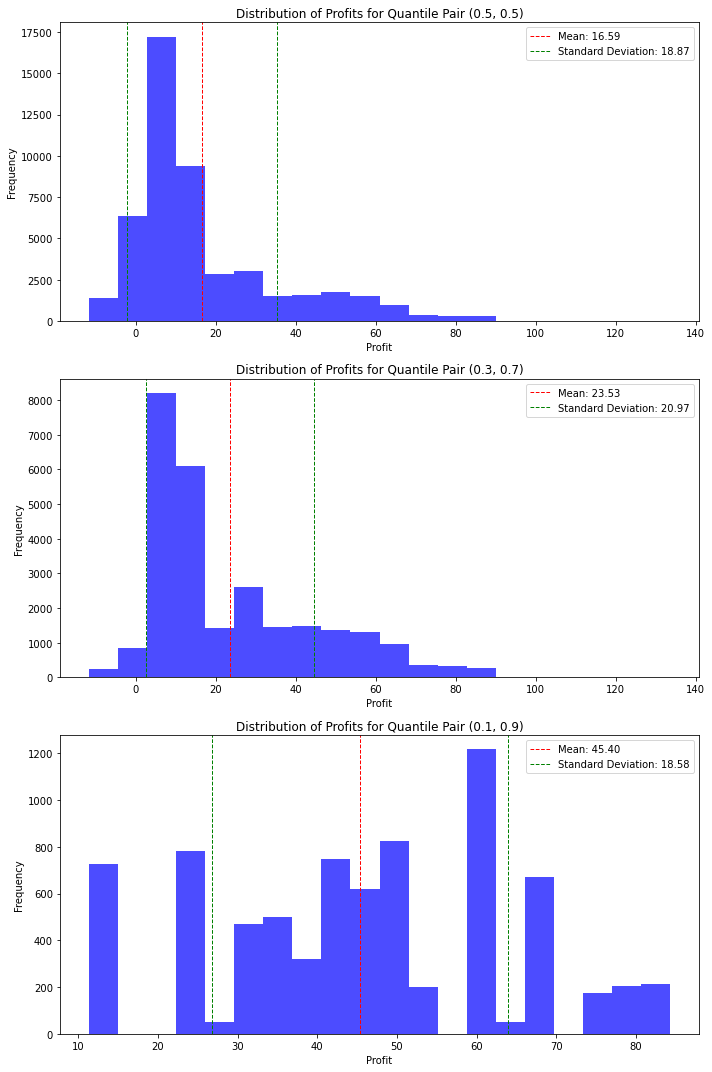

In [7]:
import matplotlib.pyplot as plt

# Initialize lists to collect profits for each quantile pair
profits_0_5 = []
profits_0_3_0_7 = []
profits_0_1_0_9 = []

# Loop through each quantile pair
for alpha, complement_alpha in quantile_pairs:
    results = []
    current_charge = initial_charge

    for start_idx in time_periods:
        end_idx = start_idx + 24

        if end_idx > len(Y_r):
            break

        alpha_key = int(alpha * 100)
        complement_alpha_key = int(complement_alpha * 100)

        if alpha_key not in Q or complement_alpha_key not in Q:
            continue

        p_max = Q[alpha_key]["Price"].iloc[start_idx:end_idx].values
        p_min = Q[complement_alpha_key]["Price"].iloc[start_idx:end_idx].values

        prob = LpProblem("Multiple_Trades_Quantile_Strategy", LpMaximize)
        # Other constraints and objective function...

        # Solve the problem
        prob.solve()

        if LpStatus[prob.status] == 'Optimal':
            daily_profit = 0
            buy_times = [t for t in range(24) if buy[t].varValue > 0]
            sell_times = [t for t in range(24) if sell[t].varValue > 0]
            used_hours = set()

            for bt in buy_times:
                if bt in used_hours:
                    continue
                for st in sell_times:
                    if st in used_hours or bt >= st:
                        continue
                    buy_price = p_min[bt]
                    sell_price = p_max[st]
                    expected_profit = (battery_efficiency_discharge * sell_price * sell[st].varValue) - ((buy_price * buy[bt].varValue) / battery_efficiency_charge)
                    if expected_profit > 0:
                        used_hours.add(bt)
                        used_hours.add(st)
                        buy_price_real = Y_r.iloc[start_idx + bt]["Price"]
                        sell_price_real = Y_r.iloc[start_idx + st]["Price"]
                        buy_amount = buy[bt].varValue
                        sell_amount = sell[st].varValue
                        profit = (battery_efficiency_discharge * sell_price_real * sell_amount) - ((buy_price_real * buy_amount) / battery_efficiency_charge)
                        results.append(profit)

            # Append profits to the corresponding list based on the quantile pair
            if alpha == 0.5 and complement_alpha == 0.5:
                profits_0_5.extend(results)
            elif alpha == 0.3 and complement_alpha == 0.7:
                profits_0_3_0_7.extend(results)
            elif alpha == 0.1 and complement_alpha == 0.9:
                profits_0_1_0_9.extend(results)


# Function to plot histogram and add mean and standard deviation information
def plot_with_stats(profits, title):
    plt.hist(profits, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    plt.title(title)
    
    mean_profit = np.mean(profits)
    std_dev = np.std(profits)
    plt.axvline(mean_profit, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_profit:.2f}')
    plt.axvline(mean_profit + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Standard Deviation: {std_dev:.2f}')
    plt.axvline(mean_profit - std_dev, color='green', linestyle='dashed', linewidth=1)

    plt.legend()

# Plot the distribution of profits for each quantile pair separately
plt.figure(figsize=(10, 15))

# Plot for quantile pair (0.5, 0.5)
plt.subplot(3, 1, 1)
plot_with_stats(profits_0_5, 'Distribution of Profits for Quantile Pair (0.5, 0.5)')

# Plot for quantile pair (0.3, 0.7)
plt.subplot(3, 1, 2)
plot_with_stats(profits_0_3_0_7, 'Distribution of Profits for Quantile Pair (0.3, 0.7)')

# Plot for quantile pair (0.1, 0.9)
plt.subplot(3, 1, 3)
plot_with_stats(profits_0_1_0_9, 'Distribution of Profits for Quantile Pair (0.1, 0.9)')

plt.tight_layout()
plt.show()
